In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
%load_ext blackcellmagic

In [3]:
import torch

# Load ESM-1b model
original_model, alphabet = torch.hub.load(
            "facebookresearch/esm:main", model="esm1_t6_43M_UR50S"
        )
batch_converter = alphabet.get_batch_converter()
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG")
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

original_model.eval()
with torch.no_grad():
    original_results = original_model(batch_tokens, repr_layers=[6], return_contacts=False)
original_reps = original_results["representations"][6].numpy().mean(axis=1).flatten()

Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


In [60]:
# https://github.com/ChrisMats/feature-reuse/blob/main/ablations/layer_importance/trainer.py
import torch.nn as nn
import math

def rand_weights_init(m, sampling_fn=None):  
    if sampling_fn is None:
        if isinstance(m, nn.Conv2d):
            print(f"conv2d, changing {m} with type {type(m)}")
            nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5)) 
            if m.bias is not None:
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(m.bias, -bound, bound)
        else:
            print(f"not conv2d, cannot change {m} with type {type(m)})")        
        if isinstance(m, nn.Linear):
            print(f"linear, changing {m} with type {type(m)}")
            nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5)) 
            if m.bias is not None:
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
                print(fan_in, bound)
                nn.init.uniform_(m.bias, -bound, bound) 
        else:
            print(f"not linear, cannot change {m} with type {type(m)})")
    else:
        tmp_state = m.state_dict()
        for name_, module_ in m.named_modules():
            if isinstance(module_, (nn.Linear,nn.Conv2d)):
                print(f"either linear or conv2d changing {m} with type {type(m)}")
                weight_name = f"{name_}{'.' if name_ else ''}weight"
                bias_name = f"{name_}{'.' if name_ else ''}bias"
                tmp_state[weight_name] = sampling_fn(tmp_state[weight_name])
                if bias_name in tmp_state:
                    tmp_state[bias_name] = sampling_fn(tmp_state[bias_name]) 
            else:
                print(f"not linear nor conv, cannot change {m} with type {type(m)})")        
        m.load_state_dict(tmp_state)

In [9]:
from scr.params.sys import DEVICE

In [61]:
import copy
model = copy.deepcopy(original_model).to(DEVICE)

for name, layer in model.named_modules():
    if name in ["layers.0", ]:
        print(f"changing {name}")
        pre_rand_weight = layer.state_dict()['fc1.weight'].cpu().numpy()
        pre_rand_bias = layer.state_dict()['fc1.bias'].cpu().numpy()
        # layer.apply(lambda m: rand_weights_init(m=m, sampling_fn = nn.init.uniform_))
        layer.apply(lambda m: rand_weights_init(m=m, sampling_fn = None))
        
        post_rand_weight = layer.state_dict()['fc1.weight'].cpu().numpy()
        post_rand_bias = layer.state_dict()['fc1.bias'].cpu().numpy()

        print(layer.state_dict().keys())

changing layers.0
not conv2d, cannot change Linear(in_features=768, out_features=768, bias=True) with type <class 'torch.nn.modules.linear.Linear'>)
linear, changing Linear(in_features=768, out_features=768, bias=True) with type <class 'torch.nn.modules.linear.Linear'>
768 0.036084391824351615
not conv2d, cannot change Linear(in_features=768, out_features=768, bias=True) with type <class 'torch.nn.modules.linear.Linear'>)
linear, changing Linear(in_features=768, out_features=768, bias=True) with type <class 'torch.nn.modules.linear.Linear'>
768 0.036084391824351615
not conv2d, cannot change Linear(in_features=768, out_features=768, bias=True) with type <class 'torch.nn.modules.linear.Linear'>)
linear, changing Linear(in_features=768, out_features=768, bias=True) with type <class 'torch.nn.modules.linear.Linear'>
768 0.036084391824351615
not conv2d, cannot change Linear(in_features=768, out_features=768, bias=True) with type <class 'torch.nn.modules.linear.Linear'>)
linear, changing Lin

In [74]:
a, b, c = 1, 1, 768
r1, r2 = 0, 1
t1 = torch.FloatTensor(a, b, c).uniform_(r1, r2)
torch.FloatTensor(t1.shape).uniform_(r1, r2).shape

torch.Size([1, 1, 768])

In [10]:
import copy
model = copy.deepcopy(original_model).to(DEVICE)

pre_weights = {}
post_weights = {}
        
for name, param in model.named_parameters():
    if "layers.0" in name:
        pre_weights[name] = param.data
        param.data = torch.FloatTensor(param.shape).uniform_(param.min().detach(), param.max().detach())
        post_weights[name] = param.data


In [88]:
pre_weights.keys()

dict_keys(['layers.0.self_attn.bias_k', 'layers.0.self_attn.bias_v', 'layers.0.self_attn.k_proj.weight', 'layers.0.self_attn.k_proj.bias', 'layers.0.self_attn.v_proj.weight', 'layers.0.self_attn.v_proj.bias', 'layers.0.self_attn.q_proj.weight', 'layers.0.self_attn.q_proj.bias', 'layers.0.self_attn.out_proj.weight', 'layers.0.self_attn.out_proj.bias', 'layers.0.self_attn_layer_norm.weight', 'layers.0.self_attn_layer_norm.bias', 'layers.0.fc1.weight', 'layers.0.fc1.bias', 'layers.0.fc2.weight', 'layers.0.fc2.bias', 'layers.0.final_layer_norm.weight', 'layers.0.final_layer_norm.bias'])

In [5]:
import matplotlib.pyplot as plt

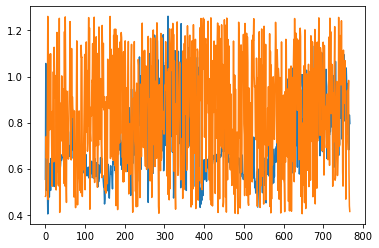

In [11]:
plt.plot(pre_weights["layers.0.final_layer_norm.weight"])
plt.plot(post_weights["layers.0.final_layer_norm.weight"])

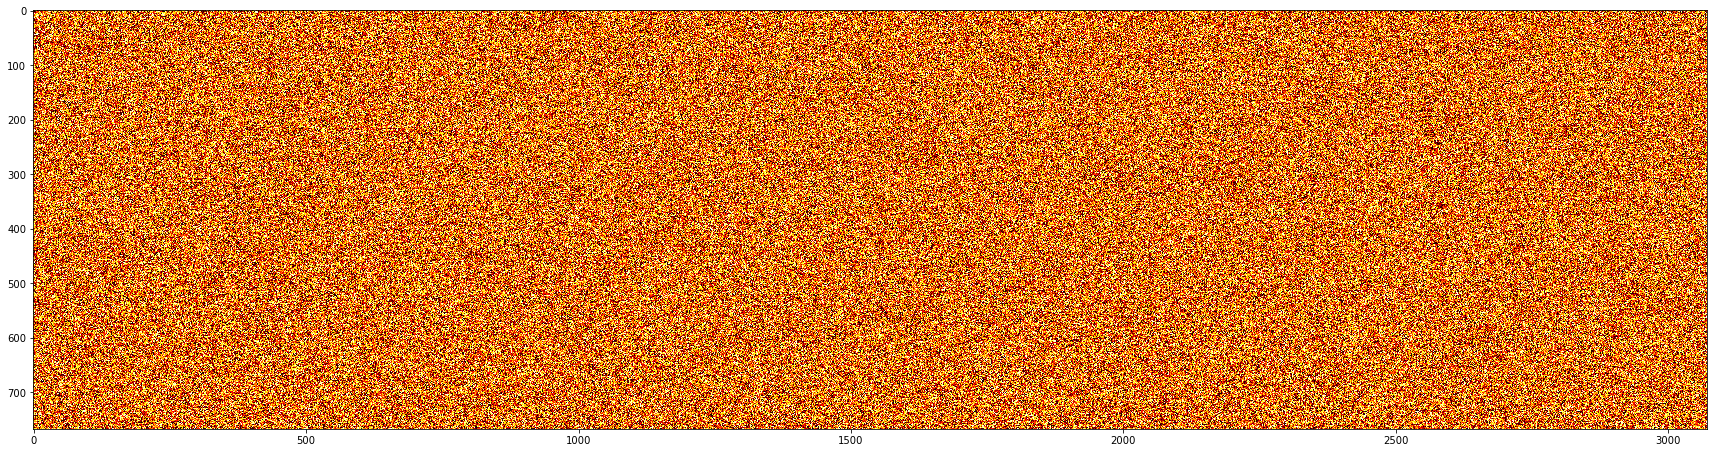

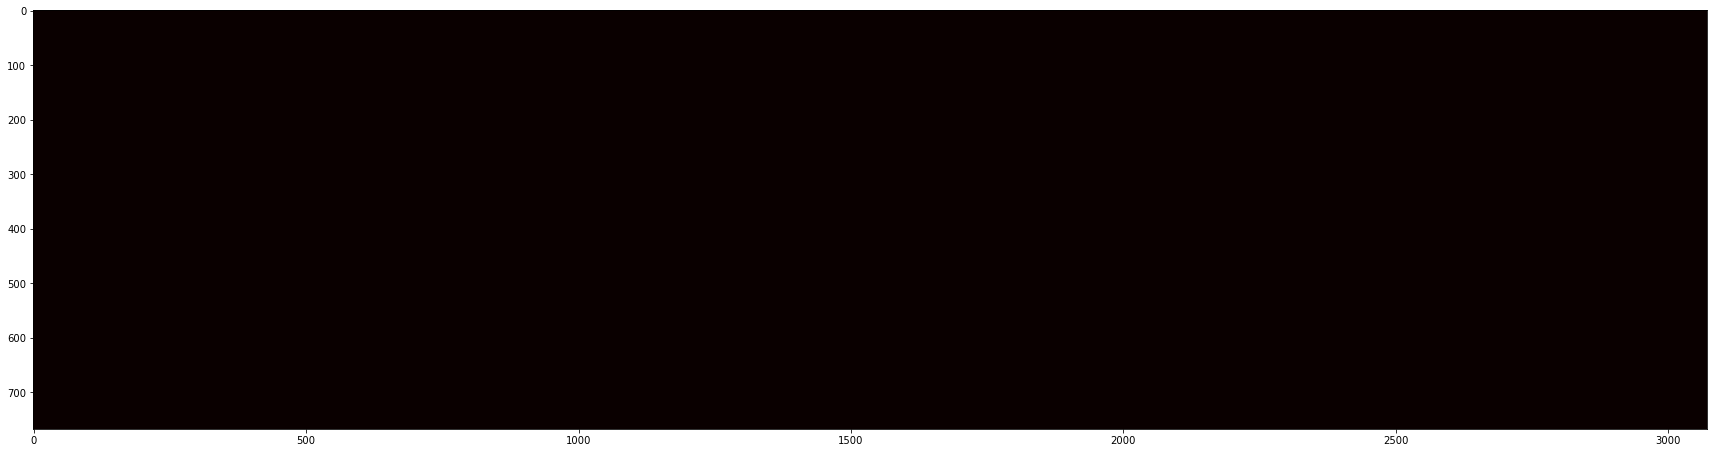

In [63]:
plt.figure(figsize=(30,8))
plt.imshow(pre_rand_weight.T, cmap="hot", interpolation='nearest')
plt.figure(figsize=(30,8))
plt.imshow(pre_rand_weight.T - post_rand_weight.T, cmap="hot", interpolation='nearest')

(array([ 18., 105., 265., 104.,  77.,  85.,  56.,  43.,  11.,   4.]),
 array([0.4033203 , 0.48916015, 0.575     , 0.66083986, 0.74667966,
        0.83251953, 0.9183594 , 1.0041993 , 1.090039  , 1.1758789 ,
        1.2617188 ], dtype=float32),
 <BarContainer object of 10 artists>)

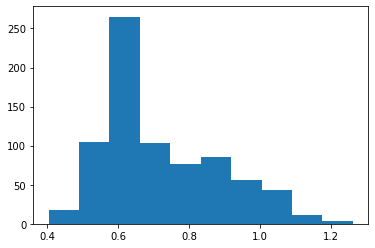

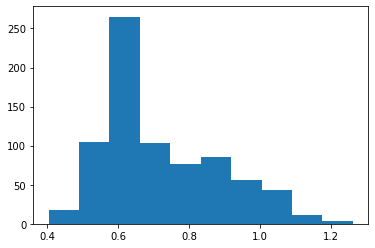

In [ ]:
plt.hist(pre_rand_weight)
plt.figure()
plt.hist(post_rand_weight)

In [12]:
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=False)
reps = results["representations"][6].numpy().mean(axis=1).flatten()

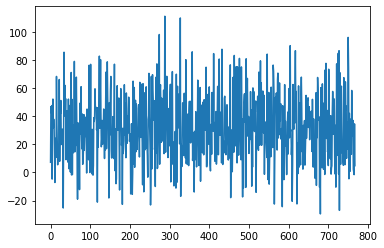

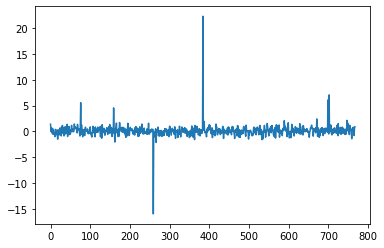

In [13]:
plt.plot(reps)
plt.figure()
plt.plot(original_reps)

In [7]:
for l in model.layers.children():
  try:
    nn.init.kaiming_normal_(l.weight)
    l.bias.data.zero_()
  except:
    pass

def stats(x): return x.mean(),x.std()


for i,e in enumerate(model.layers.children()):
  print(i,e)
  print('-----Layer Mean and std',stats(e.weight))

0 TransformerLayer(
  (self_attn): MultiheadAttention(
    (k_proj): Linear(in_features=768, out_features=768, bias=True)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (self_attn_layer_norm): ESM1LayerNorm()
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
  (final_layer_norm): ESM1LayerNorm()
)


AttributeError: 'TransformerLayer' object has no attribute 'weight'

In [ ]:
"""
layer.weight.data.fill_(random_weight)
layer.bias.data.fill_(random_bias)
"""

In [28]:
model.layers[0]

TransformerLayer(
  (self_attn): MultiheadAttention(
    (k_proj): Linear(in_features=768, out_features=768, bias=True)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (self_attn_layer_norm): ESM1LayerNorm()
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
  (final_layer_norm): ESM1LayerNorm()
)

In [27]:
[p.shape for p in model.layers[0].parameters()]

[torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([768, 768]),
 torch.Size([768]),
 torch.Size([768, 768]),
 torch.Size([768]),
 torch.Size([768, 768]),
 torch.Size([768]),
 torch.Size([768, 768]),
 torch.Size([768]),
 torch.Size([768]),
 torch.Size([768]),
 torch.Size([3072, 768]),
 torch.Size([3072]),
 torch.Size([768, 3072]),
 torch.Size([768]),
 torch.Size([768]),
 torch.Size([768])]

In [ ]:
# https://discuss.pytorch.org/t/how-to-change-the-weights-of-a-pytorch-model/41279/3

"""
model.eval()  
    with torch.no_grad():
        for data, target  in test_loader:
            data, target = data.to(device), target.to(device)
            model.fc.weight = model.fc.weight * attention_matrix
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
"""

# model.fc.weight = torch.nn.parameter.Parameter( model.fc.weight * attention_matrix )